In [1]:
import pandas as pd
import numpy as np
import json

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from config import Config

In [2]:
# Load model, test set, and prediction
model = load_model("models/models/nn_model.keras")
test_df = pd.read_csv("datasets/preds_test.csv")
X_te = np.load("datasets/X_test_preproc.npy")

In [3]:
# Load threshold
with open("datasets/best_threshold.json", 'r') as f:
    threshold = json.load(f)

In [4]:
# Threshold 
acc_thr = threshold["acc"]
f1_thr = threshold["f1"]

In [5]:
# Extract test columns
y_true = test_df["y_test"]
y_proba = test_df["gb_test"]

In [6]:
# Apply predictions
y_pred_f1 = (y_proba>=f1_thr).astype(int)
y_pred_acc = (y_proba>=acc_thr).astype(int)

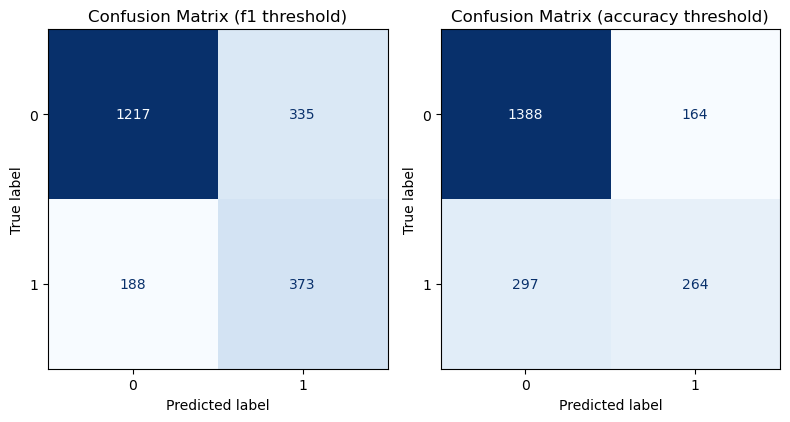

In [7]:
# Confusion matrix with different thresholds
cm_f1 = confusion_matrix(y_true,y_pred_f1)
cm_acc = confusion_matrix(y_true,y_pred_acc)

fig, axes = plt.subplots(1,2,figsize=(8,5))
disp_f1 = ConfusionMatrixDisplay(confusion_matrix=cm_f1)
disp_f1.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title(f"Confusion Matrix (f1 threshold)")
disp_acc = ConfusionMatrixDisplay(confusion_matrix=cm_acc)
disp_acc.plot(ax=axes[1], cmap="Blues", colorbar=False)
axes[1].set_title(f"Confusion Matrix (accuracy threshold)")

plt.tight_layout()
plt.show()

In [8]:
# Load feature names
with open("datasets/feature_names.json") as f:
    feature_names = json.load(f)

In [9]:
# Permutation importance 
def auprc_score(model, X, y):
    from sklearn.metrics import average_precision_score
    probas = model.predict(X, verbose=0).ravel()
    return average_precision_score(y, probas)

perm_importance = permutation_importance(
    estimator=model,
    X=X_te,
    y=y_true,
    scoring=auprc_score,
    n_repeats=20,
    random_state=42,
    n_jobs=1
)

In [10]:
top_n = 5
highlight_colour = '#1f77b4'
non_highlight_colour = '#C9CCD1'

metric = "AUPRC"
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]
means = perm_importance.importances_mean[sorted_idx]
feat_labels = np.asarray(feature_names)[sorted_idx]

perm_values = perm_importance.importances.T
medians = np.median(perm_values, axis=0)
sorted_boxidx = np.argsort(medians)[::-1]
sorted_medians = medians[sorted_boxidx]
sort_feat = np.array(feature_names)[sorted_boxidx]
perm_df = pd.DataFrame(perm_values, columns=feature_names)[sort_feat]
perm_df_long = perm_df.melt(var_name="Feature", value_name="Importance")
perm_df_long["Feature"] = pd.Categorical(perm_df_long["Feature"], categories=sort_feat, ordered=True)

bar_colours = [highlight_colour if i < top_n else non_highlight_colour for i in range(len(means))]
palette = {feat: (highlight_colour if i < top_n else non_highlight_colour) for i, feat in enumerate(sort_feat)}

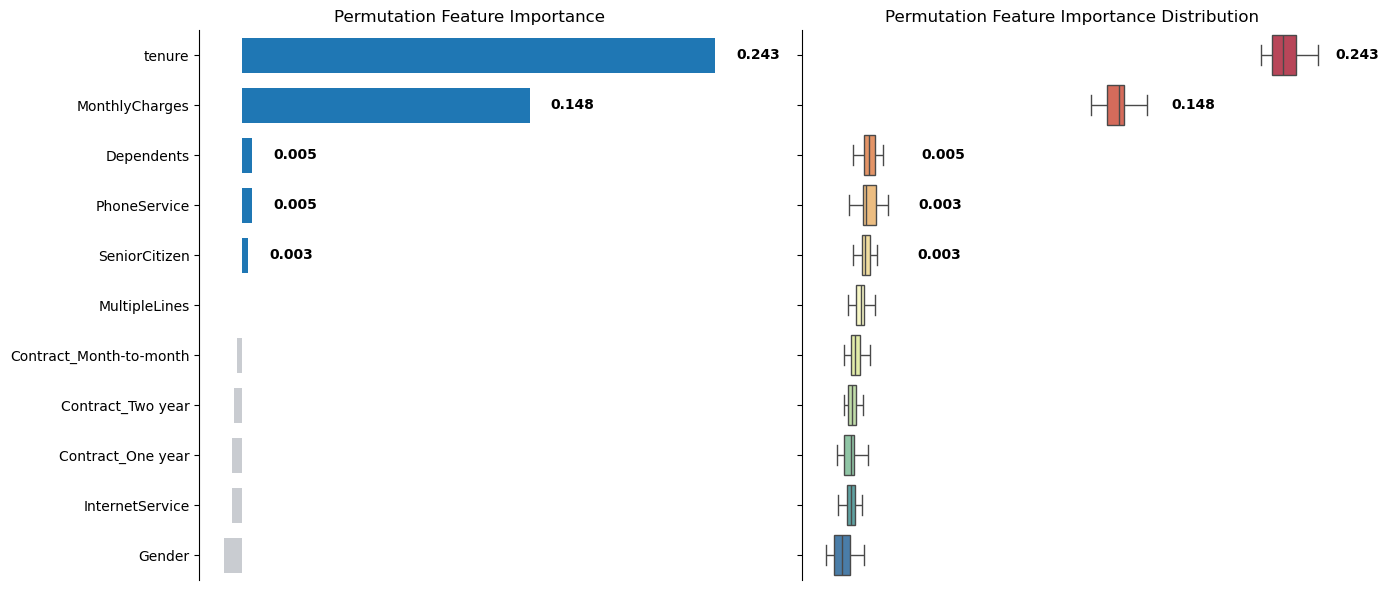

In [11]:
# Plot PFI
fig, (ax_bar, ax_box) = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Bar-sub
bars = ax_bar.barh(range(len(sorted_idx)), means, height=0.7, color=bar_colours)
labels = [f"{v:.3f}" if i < top_n else '' for i, v in enumerate(means)]
ax_bar.invert_yaxis()
ax_bar.set_xlabel(f"Mean decrease in {metric}")
ax_bar.set_title("Permutation Feature Importance")
ax_bar.spines[['right', 'top', 'bottom']].set_visible(False) 
ax_bar.xaxis.set_visible(False)
ax_bar.bar_label(bars, labels=labels, fmt='%.3f', padding=15, label_type='edge', fontweight='bold', color="black")
plt.yticks(range(len(sorted_idx)), feat_labels)

# Box-sub
x_pad = 0.03
sns.boxplot(data=perm_df_long, 
            y="Feature", 
            x="Importance", 
            order=sort_feat, 
            ax=ax_box, 
            palette="Spectral",
            showfliers=False)
for i in range(top_n):
    ax_box.text(sorted_medians[i] + x_pad, i, f"{sorted_medians[i]:.3f}", va="center", ha="left", 
                fontsize=10, fontweight="bold", color="black", clip_on=False)
ax_box.set_xlabel(f"{metric} decrease in PFI")
ax_box.set_title("Permutation Feature Importance Distribution")
ax_box.spines[['right', 'top', 'bottom']].set_visible(False) 
ax_box.xaxis.set_visible(False)

plt.tight_layout()
plt.show()

In [12]:
X_te_df = pd.read_csv("datasets/df_plot.csv")

In [13]:
for col in X_te_df.columns:
    lo = np.quantile(X_te_df[col], 0.05)
    hi = np.quantile(X_te_df[col], 0.95)

    if lo == hi:
        print({col})

In [14]:
# Custom pdp
# Define x-axis range
def build_grid(X, feat_idx, n=30, q_low=0.05, q_high=0.95): # Remove outliers
    lo = np.quantile(X[:,feat_idx], q_low)
    hi = np.quantile(X[:,feat_idx], q_high)
    if lo == hi:
        hi = lo + 1e-6
    return np.linspace(lo, hi, n)

In [15]:
def pdp(model, X, i1, i2, n=(30,30), sub=2000):
    n1, n2 = n
    if sub is not None and X.shape[0] > sub:
        rng = np.random.default_rng(42)
        rows = rng.choice(X.shape[0], sub, replace=False)
        X0 = X[rows].copy()
    else:
        X0 = X.copy()
    g1 = build_grid(X0, i1, n1)
    g2 = build_grid(X0, i2, n2)
    Z = np.empty((n1,n2), dtype=float) # Fill grid

    for i, v1 in enumerate(g1):
        X1 = X0.copy()
        X1[:,i1] = v1
        for j, v2 in enumerate(g2):
            X2=X1.copy()
            X2[:,i2] = v2
            p = model.predict(X2, verbose=0).reshape(-1)
            Z[i,j] = p.mean()
    return g1, g2, Z

In [16]:
# Plot heatmap
tenure = "tenure"
t_idx = feature_names.index(tenure)
other_feats = [f for f in feature_names if f!= tenure]

In [17]:
# Set rows and columns
n = len(other_feats)
ncols = 4
nrows = int(np.ceil(n/ncols))

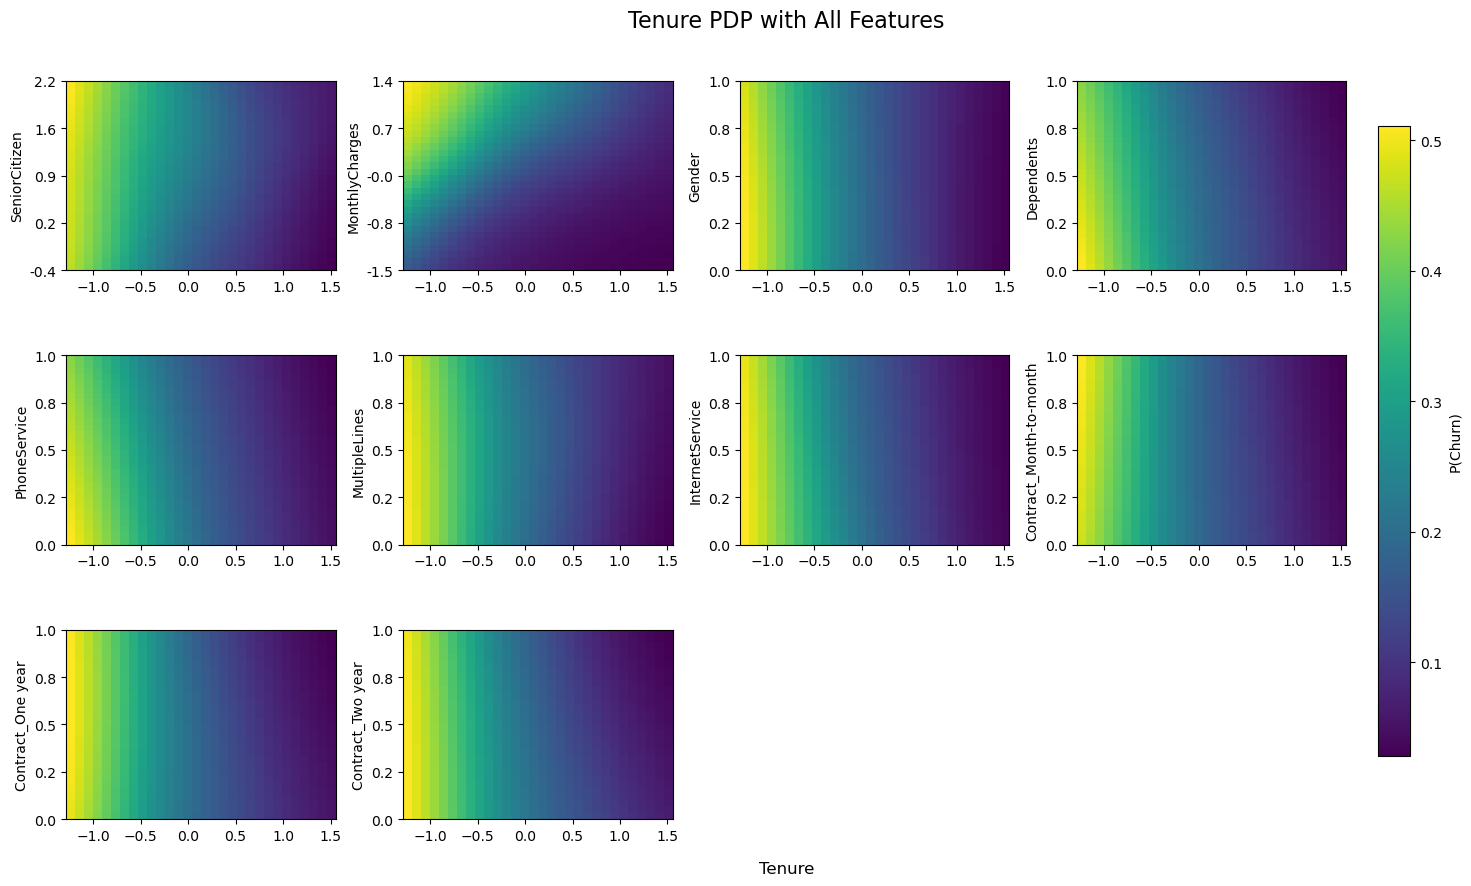

In [18]:
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), constrained_layout=False)
axes = np.array(axes).reshape(-1)
img = None
for ax, f in zip(axes, other_feats):
    f_idx = feature_names.index(f)
    g1, g2, Z = pdp(model, X_te, t_idx, f_idx, n=(30,30), sub=2000)

    # Show heatmap
    img = ax.imshow(Z.T, origin="lower", 
                    extent=[g1.min(), g1.max(), 
                            g2.min(), g2.max()], 
                    aspect="auto")
    ax.set_xlabel("")
    ax.set_ylabel(f)
    ax.set_yticks(np.linspace(g2.min(),g2.max(),5))
    ax.set_yticklabels([f"{v:.1f}" for v in np.linspace(g2.min(),g2.max(),5)])
    
for k in range(len(other_feats), len(axes)):
    axes[k].axis("off")
    
fig.suptitle("Tenure PDP with All Features", fontsize=16, y=0.98)
fig.text(0.5, 0.02, "Tenure", ha="center", fontsize=12)
fig.subplots_adjust(top=0.90, bottom=0.08, left=0.05, right=0.85, hspace=0.45, wspace=0.25)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label("P(Churn)")
plt.show()

In [19]:
X_raw = pd.read_csv(Config.DATA_URL)
X_raw["idx"]=X_raw.index
X_raw.head(1)

,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,InternetService,Contract,MonthlyCharges,Churn,idx
0,Female,0,No,1,No,No,DSL,Month-to-month,25,Yes,0


In [20]:
df_plot = pd.read_csv("datasets/df_plot.csv")
df_plot["idx"]=df_plot.index
df_plot.head(1)

,Unnamed: 0,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,p_churn,idx
0,4835,2.22676,-1.284905,-0.824387,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.679393,0


In [21]:
X_raw_cat = X_raw.filter(["InternetService", "Contract", "MonthlyCharges", "idx"], axis=1)
df_plot_churn = df_plot.filter(["idx", "p_churn"], axis=1)

In [22]:
cat_churn = pd.merge(X_raw_cat, df_plot_churn, left_on="idx", right_on="idx")
cat_churn.head(1)

,InternetService,Contract,MonthlyCharges,idx,p_churn
0,DSL,Month-to-month,25,0,0.679393


In [23]:
cat_churn["MonthlyCharges"].describe()

count    2113.000000
mean       64.678183
std        29.975046
min        19.000000
25%        36.000000
50%        70.000000
75%        90.000000
max       119.000000
Name: MonthlyCharges, dtype: float64

In [24]:
# Facet plot Monthly charges with services and contracts
df= cat_churn.copy()

contract_ord = pd.CategoricalDtype(["Month-to-month", "One year", "Two year"], ordered=True)
df["Contract"] = df["Contract"].astype(contract_ord)

In [25]:
# Set boundary
lo = int(np.floor(df["MonthlyCharges"].min()/20)*20)
hi = int(np.ceil(df["MonthlyCharges"].max()/20)*20)
edges = list(range(lo, hi+20, 20))
df["charge_bins"] = pd.cut(cat_churn["MonthlyCharges"], bins=edges, labels=None, include_lowest=True, right=True)
cats = df["charge_bins"].cat.categories
mid = pd.Series([iv.mid for iv in cats], index=cats)
df["bin_mid"] = df["charge_bins"].map(mid)

In [26]:
# Set ticks
ticklabel = [f"({int(iv.left)}, {int(iv.right)})" for iv in cats]
tickpost = [iv.mid for iv in cats]

In [27]:
df_fc = (df.groupby(["Contract", "InternetService", "charge_bins"], as_index=False)["p_churn"].mean())

In [28]:
df_fc["bin_mid"] = df_fc["charge_bins"].map(mid)

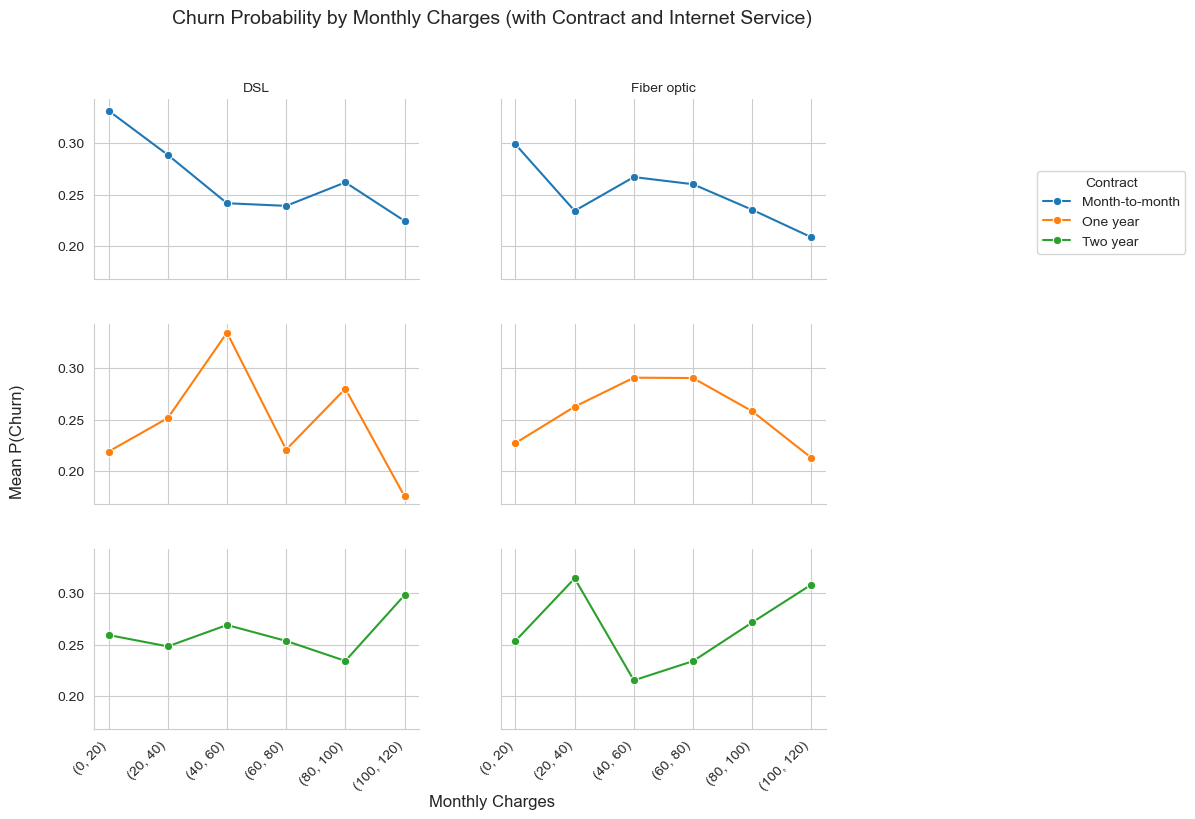

In [29]:
# Set facet
sns.set_style("whitegrid")
g = sns.FacetGrid(df_fc.sort_values(["Contract", "InternetService", "bin_mid"]), 
                  row="Contract", col="InternetService", 
                  hue="Contract", margin_titles=True, 
                  sharex=True, sharey=True, 
                  height=3.0, aspect=1.5)
g.map_dataframe(sns.lineplot, x="bin_mid", y="p_churn", marker="o")

# Shared label
g.set_xlabels("")
g.set_ylabels("")
for ax in g.axes.flat:
    g.set_xlabels("")
    g.set_ylabels("")
    ax.set_xticks(tickpost)
    ax.set_xticklabels(ticklabel, rotation=45, ha="right")

g.set_titles(col_template="{col_name}", row_template="")
g.figure.text(0.5, 0.1, "Monthly Charges", ha="center", va="center", fontsize=12)
g.figure.text(0.04, 0.5, "Mean P(Churn)", va="center", rotation="vertical", fontsize=12)

g.figure.suptitle("Churn Probability by Monthly Charges (with Contract and Internet Service)", fontsize=14, y=0.98)
g.figure.subplots_adjust(bottom=0.18, top=0.88, left=0.12, right=0.85, wspace=0.25, hspace=0.25)
g.add_legend(title="Contract", bbox_to_anchor=(1.02,0.8), loc="upper left", borderaxespad=0, frameon=True)
plt.show()